In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import os

def word_segmentation(image_path, output_folder_path):

  try:
    img = cv2.imread(image_path)
  except FileNotFoundError:
    print(f"Error: Image file not found at '{image_path}'.")
    return

  if img is None:
    print(f"Error: OpenCV failed to read the image at '{image_path}'.")
    return

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#if the width of image is greater than 1000 then the image is resized maintaining the same aspect ratio.

  h, w, c = img.shape
  if w > 1000:
    new_w = 1000
    ar = w / h
    new_h = int(new_w / ar)
    img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

  # Preprocessing
  def thresholding(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img_gray, 120, 255, cv2.THRESH_BINARY_INV)
    return thresh

  thresh_img = thresholding(img)

  # Dilation
  kernel = np.ones((3, 85), np.uint8)
  dilated = cv2.dilate(thresh_img, kernel, iterations=1)

  # Line segmentation
  (contours, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  sorted_contours_lines = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[1])  # (x, y, w, h)

  # Create the output folder if it doesn't exist
  if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

  # Text segmentation
  kernel = np.ones((3, 15), np.uint8)
  dilated2 = cv2.dilate(thresh_img, kernel, iterations=1)

  words_list = []
  for line in sorted_contours_lines:
    x, y, w, h = cv2.boundingRect(line)
    roi_line = dilated2[y:y + h, x:x + w]

    (cnt, hierarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contour_words = sorted(cnt, key=lambda cntr: cv2.boundingRect(cntr)[0])

    for word in sorted_contour_words:
      if cv2.contourArea(word) < 400:
        continue

      x2, y2, w2, h2 = cv2.boundingRect(word)
      word_roi = img[y + y2:y + y2 + h2, x + x2:x + x2 + w2]

      # Generate unique filename
      filename = f"word_{len(words_list)}.jpg"
      filepath = os.path.join(output_folder_path, filename)

      # Save the segmented word image
      cv2.imwrite(filepath, word_roi)
      words_list.append(filepath)

def process_folder(input_folder_path, output_main_folder_path):

  for root, _, files in os.walk(input_folder_path):
    for file in files:
      if file.endswith((".jpg", ".jpeg", ".png")):
        image_path = os.path.join(root, file)
        subfolder_name = os.path.basename(root)  # Get the subfolder name
        output_subfolder_path = os.path.join(output_main_folder_path, subfolder_name)
        os.makedirs(output_subfolder_path, exist_ok=True)  # Create subfolder if it doesn't exist

        try:
          word_segmentation(image_path, output_subfolder_path)
        except Exception as e:
          print(f"Error processing image '{image_path}': {e}")

input_folder_path = "/content/drive/MyDrive/MAJOR_WORULER-20240213T114158Z-001/MAJOR_WORULER"
output_main_folder_path = "/content/drive/MyDrive/segmenataion.major"
process_folder(input_folder_path, output_main_folder_path)



In [ ]:

from google.colab.patches import cv2_imshow

# Preprocess handwritten text images
def preprocess_image(image_path):
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Binarize image
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Apply noise reduction
    denoised_image = cv2.fastNlMeansDenoising(binary_image, None, 10, 7, 21)

    # Detect edges
    edges = cv2.Canny(denoised_image, 50, 150)

    return edges



if __name__ == "__main__":
    # Specify the path to the folder containing the dataset
    data_folder = "/content/drive/MyDrive/segmenataion.major"

    # Specify the path to the folder to save preprocessed images
    output_folder = "/content/drive/MyDrive/preprossed_images_seg"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through each state folder in the dataset
    for state_folder in os.listdir(data_folder):
        state_path = os.path.join(data_folder, state_folder)
        output_state_path = os.path.join(output_folder, state_folder)
        if not os.path.exists(output_state_path):
            os.makedirs(output_state_path)

        # Loop through each image file in the state folder
        for file in os.listdir(state_path):
            image_path = os.path.join(state_path, file)

            # Preprocess the image
            preprocessed_image = preprocess_image(image_path)

            # Save the preprocessed image
            output_path = os.path.join(output_state_path, file)
            cv2.imwrite(output_path, preprocessed_image)

            # Display the preprocessed image
           # cv2_imshow(preprocessed_image)

In [ ]:
import cv2
import os
import numpy as np

def extract_features_from_image(image_path, image_label, resize_dim=(128, 128)):

    preprocessed_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if resize_dim is not None:
        resized_image = cv2.resize(preprocessed_image, resize_dim, interpolation=cv2.INTER_AREA)
    else:
        resized_image = preprocessed_image

    winSize = (64, 128)   # Default window size used in HOGDescriptor
    blockSize = (16, 16)  # Size of the block over which histogram counts are accumulated
    blockStride = (8, 8)  # Block stride, indicating the stride for sliding the block window
    cellSize = (8, 8)     # Size of the cell
    nbins = 9             # Number of bins for the histogram

    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    hog_features = hog.compute(resized_image)

    # Checking if the features are extracted
    if hog_features is not None and len(hog_features) > 0:
        print(f"Image Label: {image_label}")
        print("HOG Features:")
        print(hog_features)
        return hog_features
    else:
        print(f"Features couldn't be extracted for image: {image_path}")
        return None


def process_folder(main_folder, resize_dim=(128, 128)):

    for class_folder in os.listdir(main_folder):
        class_path = os.path.join(main_folder, class_folder)

        for file in os.listdir(class_path):
            image_path = os.path.join(class_path, file)

            # Extract features from image and print HOG features with class folder
            extract_features_from_image(image_path, class_folder, resize_dim)

main_folder = "/content/drive/MyDrive/preprossed_images_seg"
resize_dim = (128, 128)
process_folder(main_folder, resize_dim)


Image Label: KERALA
HOG Features:
[0.16486377 0.02009113 0.00765695 ... 0.10345659 0.07563611 0.22718334]
Image Label: KERALA
HOG Features:
[0. 0. 0. ... 0. 0. 0.]
Image Label: KERALA
HOG Features:
[0.07408369 0.00876248 0.02622069 ... 0.         0.         0.        ]
Image Label: KERALA
HOG Features:
[0.32022858 0.09544553 0.09486201 ... 0.         0.         0.        ]
Image Label: KERALA
HOG Features:
[0.22614889 0.02103718 0.06295124 ... 0.         0.         0.        ]
Image Label: KERALA
HOG Features:
[0. 0. 0. ... 0. 0. 0.]
Image Label: KERALA
HOG Features:
[0.32424366 0.02535095 0.04617823 ... 0.         0.         0.        ]
Image Label: KERALA
HOG Features:
[0.16212282 0.05765408 0.01012852 ... 0.04088202 0.0944997  0.304041  ]
Image Label: KERALA
HOG Features:
[0.35028622 0.04149395 0.04220459 ... 0.02887435 0.03009481 0.33966908]
Image Label: KERALA
HOG Features:
[0.00717003 0.00013811 0.00041327 ... 0.00016554 0.00922389 0.07010265]
Image Label: KERALA
HOG Features:
[0

In [ ]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
import cv2

def extract_features_from_image(image_path, resize_dim=(128, 128)):


    # Load preprocessed image
    preprocessed_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize image (optional)
    if resize_dim is not None:
        resized_image = cv2.resize(preprocessed_image, resize_dim, interpolation=cv2.INTER_AREA)
    else:
        resized_image = preprocessed_image

    # Extract features using HOG
    hog = cv2.HOGDescriptor()
    hog_features = hog.compute(resized_image)

    return hog_features.flatten()

def train_svm_model_with_cv(main_folder, test_size=0.2, folds=10):

    X = []  # Features
    y = []  # Labels

    # Loop through each subfolder (each class)
    for class_folder in os.listdir(main_folder):
        class_path = os.path.join(main_folder, class_folder)

        # Loop through each image file in the class folder
        for file in os.listdir(class_path):

            y.append(class_folder)
            image_path = os.path.join(class_path, file)
            hog_features = extract_features_from_image(image_path)
            X.append(hog_features)

    # Convert labels to numeric values
    labels = np.unique(y)
    label_dict = {label: idx for idx, label in enumerate(labels)}
    y = np.array([label_dict[label] for label in y])

    # Feature Scaling using MinMaxScaler
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # 10-fold cross-validation
    svm = SVC(kernel='linear')
    scores = cross_val_score(svm, X_scaled, y, cv=folds, scoring='accuracy')

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=42)

    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    # Print overall evaluation metrics
    print("Overall Evaluation Metrics:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)

    return svm, X_test, y_test, accuracy, precision, recall

main_folder = "/content/drive/MyDrive/preprossed_images_seg"
svm_model, X_test, y_test, accuracy, precision, recall = train_svm_model_with_cv(main_folder)


y_pred = svm_model.predict(X_test)

# Print individual image classifications
print("\nIndividual Image Classifications:")
for i, (true_label, pred_label) in enumerate(zip(y_test, y_pred)):
    print(f"Image {i+1}: True Label = {true_label}, Predicted Label = {pred_label}")


Overall Evaluation Metrics:
Accuracy: 0.6756756756756757
Precision: 0.6739106453392167
Recall: 0.6756756756756757

Individual Image Classifications:
Image 1: True Label = 1, Predicted Label = 1
Image 2: True Label = 3, Predicted Label = 1
Image 3: True Label = 1, Predicted Label = 1
Image 4: True Label = 4, Predicted Label = 0
Image 5: True Label = 3, Predicted Label = 3
Image 6: True Label = 4, Predicted Label = 4
Image 7: True Label = 3, Predicted Label = 3
Image 8: True Label = 1, Predicted Label = 1
Image 9: True Label = 1, Predicted Label = 3
Image 10: True Label = 3, Predicted Label = 4
Image 11: True Label = 3, Predicted Label = 4
Image 12: True Label = 0, Predicted Label = 0
Image 13: True Label = 1, Predicted Label = 1
Image 14: True Label = 3, Predicted Label = 3
Image 15: True Label = 1, Predicted Label = 1
Image 16: True Label = 0, Predicted Label = 0
Image 17: True Label = 4, Predicted Label = 3
Image 18: True Label = 4, Predicted Label = 4
Image 19: True Label = 1, Predic

# Word Segmentation

## Importing

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Reading and resizing

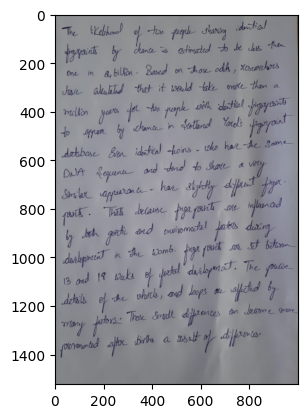

In [ ]:
img = cv2.imread('/content/drive/MyDrive/MAJOR_WORULER-20240213T114158Z-001/MAJOR_WORULER/TELUGU/Copy of telugu_1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w, c = img.shape

if w > 1000:

    new_w = 1000
    ar = w/h
    new_h = int(new_w/ar)

    img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
plt.imshow(img);

## Preprocessing

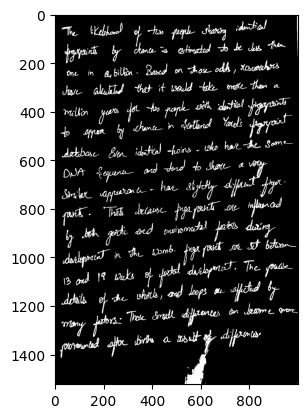

In [ ]:
def thresholding(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_gray,120,255,cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap='gray')
    return thresh

thresh_img = thresholding(img);

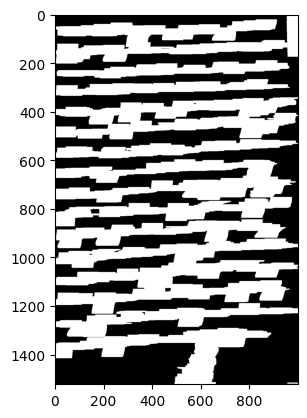

In [ ]:
#dilation
kernel = np.ones((3,85), np.uint8)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated, cmap='gray');

In [ ]:
(contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)

## Line segmentation

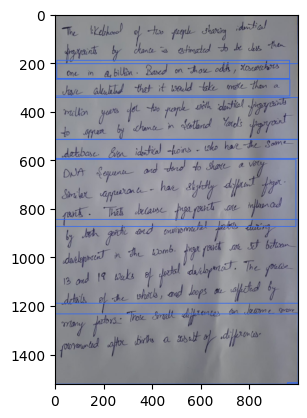

In [ ]:
img2 = img.copy()

for ctr in sorted_contours_lines:

    x,y,w,h = cv2.boundingRect(ctr)
    cv2.rectangle(img2, (x,y), (x+w, y+h), (40, 100, 250), 2)

plt.imshow(img2);

## Text segmentation

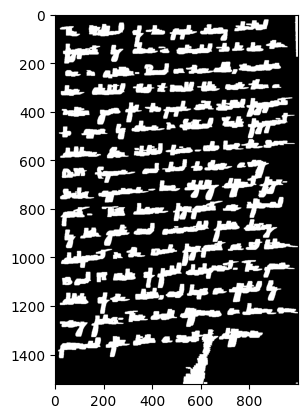

In [ ]:
#dilation
kernel = np.ones((3,15), np.uint8)
dilated2 = cv2.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated2, cmap='gray');

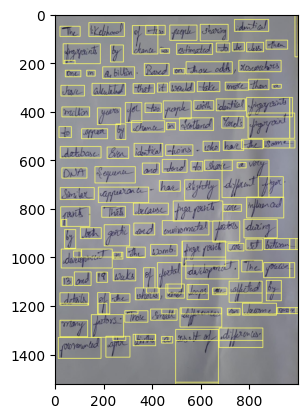

In [ ]:
img3 = img.copy()
words_list = []

for line in sorted_contours_lines:

    # roi of each line
    x, y, w, h = cv2.boundingRect(line)
    roi_line = dilated2[y:y+w, x:x+w]

    # draw contours on each word
    (cnt, heirarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contour_words = sorted(cnt, key=lambda cntr : cv2.boundingRect(cntr)[0])

    for word in sorted_contour_words:

        if cv2.contourArea(word) < 400:
            continue

        x2, y2, w2, h2 = cv2.boundingRect(word)
        words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2])
        cv2.rectangle(img3, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (255,255,100),2)

plt.imshow(img3);

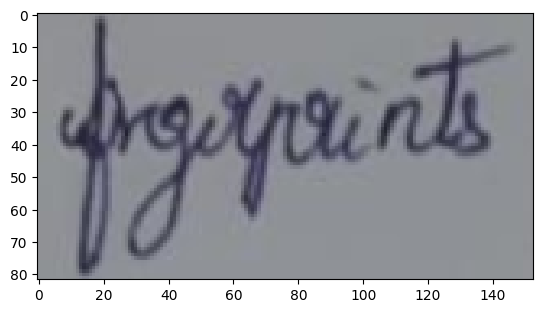

In [ ]:
ninth_word = words_list[8]
roi_9 = img[ninth_word[1]:ninth_word[3], ninth_word[0]:ninth_word[2]]
plt.imshow(roi_9);

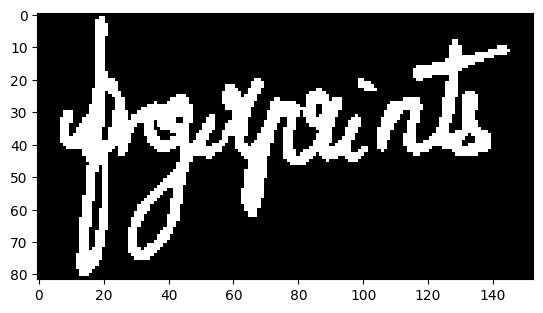

In [ ]:
def thresholding(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_gray,120,255,cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap='gray')
    return thresh

thresh_img = thresholding(roi_9);

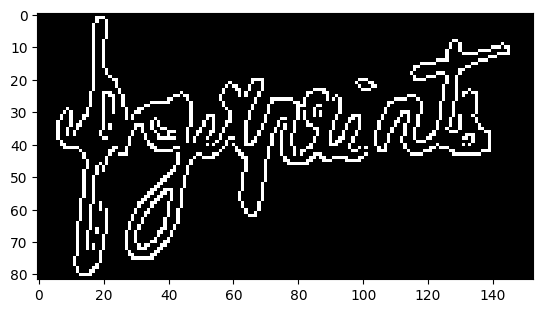

In [ ]:
def canny_edge_detection(image):
    edges = cv2.Canny(image, 50, 150)
    plt.imshow(edges, cmap='gray')
    return edges

canny_edges = canny_edge_detection(thresh_img)
plt.show()

In [ ]:
import cv2
import os
import numpy as np

def extract_features_from_image(image_path, image_label, resize_dim=(128, 128)):

    preprocessed_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if resize_dim is not None:
        resized_image = cv2.resize(preprocessed_image, resize_dim, interpolation=cv2.INTER_AREA)
    else:
        resized_image = preprocessed_image

    winSize = (64, 128)   # Default window size used in HOGDescriptor
    blockSize = (16, 16)  # Size of the block over which histogram counts are accumulated
    blockStride = (8, 8)  # Block stride, indicating the stride for sliding the block window
    cellSize = (8, 8)     # Size of the cell
    nbins = 9             # Number of bins for the histogram

    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    hog_features = hog.compute(resized_image)

    # Checking if the features are extracted
    if hog_features is not None and len(hog_features) > 0:
        print(f"Image Label: {image_label}")
        print("First five HOG Features:")
        print(hog_features[:5])  # Print only the first five feature extraction values
        return hog_features
    else:
        print(f"Features couldn't be extracted for image: {image_path}")
        return None


def process_folder(main_folder, resize_dim=(128, 128)):

    for class_folder in os.listdir(main_folder):
        class_path = os.path.join(main_folder, class_folder)

        for file in os.listdir(class_path):
            image_path = os.path.join(class_path, file)

            # Extract features from image and print HOG features with class folder
            extract_features_from_image(image_path, class_folder, resize_dim)

main_folder = "/content/drive/MyDrive/preprossed_images_seg"
resize_dim = (128, 128)
process_folder(main_folder, resize_dim)


Image Label: KERALA
First five HOG Features:
[0.16486377 0.02009113 0.00765695 0.00096432 0.01310652]
Image Label: KERALA
First five HOG Features:
[0. 0. 0. 0. 0.]
Image Label: KERALA
First five HOG Features:
[0.07408369 0.00876248 0.02622069 0.         0.06036887]
Image Label: KERALA
First five HOG Features:
[0.32022858 0.09544553 0.09486201 0.07288837 0.03609253]
Image Label: KERALA
First five HOG Features:
[0.22614889 0.02103718 0.06295124 0.         0.01289537]
Image Label: KERALA
First five HOG Features:
[0. 0. 0. 0. 0.]
Image Label: KERALA
First five HOG Features:
[0.32424366 0.02535095 0.04617823 0.0273627  0.1368379 ]
Image Label: KERALA
First five HOG Features:
[0.16212282 0.05765408 0.01012852 0.01328009 0.13118887]
Image Label: KERALA
First five HOG Features:
[0.35028622 0.04149395 0.04220459 0.02108861 0.11647578]
Image Label: KERALA
First five HOG Features:
[0.00717003 0.00013811 0.00041327 0.         0.0012366 ]
Image Label: KERALA
First five HOG Features:
[0.03896416 0.0

First five HOG Features:
[0.30922106 0.0775764  0.05749867 0.0440065  0.11690099]
Image Label: TELUGU

First five HOG Features:
[0.40716457 0.12986152 0.0103253  0.00055154 0.00132525]
Image Label: KANADA

First five HOG Features:
[0.3191054  0.06949938 0.08371244 0.05323434 0.04243694]
Image Label: ODISSA

First five HOG Features:
[0.06224582 0.0012458  0.00627205 0.01541582 0.00625812]
Image Label: TAMIL

First five HOG Features:
[0.3356982  0.03307681 0.01548702 0.02357408 0.03931141]
Image Label: KERALA


